Create a ranked time series dataset. 

Given a time series, we look at all the past time series with no overlapping segments to ensure diversity in ranked time series.  

To ensure that we have at least top 10 ranked similar time series, we will start creating data from 2019-01-01. 

And this date will be adhered to for future experiments too. 

In [23]:
import numpy as np 
import pandas as pd 
import json 
import ccxt 
from tqdm.auto import tqdm 
import pandas_ta as ta 
import seaborn as sns 
from sklearn.utils.class_weight import compute_class_weight 
from sklearn.metrics import f1_score 
import random 
import torch 
from torch import Tensor 
import torch.nn as nn
import torch.optim as optim 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader, TensorDataset, RandomSampler, SequentialSampler 
from transformers import * 
import matplotlib.pyplot as plt 
import time 
import math
import os 
from pytorch_metric_learning import miners, losses
from pytorch_metric_learning.distances import CosineSimilarity
from datetime import datetime, timedelta
from scipy.spatial.distance import cdist 
import pickle

In [5]:
### define model ### 
class PositionalEncoding(nn.Module):
        def __init__(self, d_model, dropout=0.1, max_len=5000):
                super(PositionalEncoding, self).__init__() 
                self.dropout = nn.Dropout(p=dropout) 
                pe = torch.zeros(max_len, d_model) 
                position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) 
                div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model)) 
                pe[:, 0::2] = torch.sin(position * div_term) 
                pe[:, 1::2] = torch.cos(position * div_term) 
                pe = pe.unsqueeze(0).transpose(0, 1) 
                self.register_buffer("pe", pe) 
        def forward(self, x):
                x = x + self.pe[:x.size(0), :] 
                return self.dropout(x) 

class AttentivePooling(nn.Module):
        def __init__(self, input_dim):
                super(AttentivePooling, self).__init__() 
                self.W = nn.Linear(input_dim, 1) 
        def forward(self, x):
                softmax = F.softmax
                att_w = softmax(self.W(x).squeeze(-1)).unsqueeze(-1) 
                x = torch.sum(x * att_w, dim=1) 
                return x 

# returns chart embedding 
class BTCSimCSE(nn.Module): 
        def __init__(self, chart_features, sequence_length, d_model, n_heads, num_encoders):
                super(BTCSimCSE, self).__init__() 
                self.chart_features = chart_features
                self.sequence_length = sequence_length 
                self.d_model = d_model 
                self.n_heads = n_heads 
                self.num_encoders = num_encoders 
                self.batchnorm = nn.BatchNorm1d(sequence_length) 
                self.chart_embedder = nn.Sequential(
                        nn.Linear(self.chart_features, d_model//2),
                        nn.ReLU(), 
                        nn.Linear(d_model//2, d_model)
                )
                self.pos_encoder = PositionalEncoding(d_model=self.d_model) 
                self.encoder_layers = nn.TransformerEncoderLayer(d_model=self.d_model, nhead=self.n_heads, batch_first=True)
                self.transformer_encoder = nn.TransformerEncoder(self.encoder_layers, num_layers=self.num_encoders) 
                self.attentive_pooling = AttentivePooling(input_dim=self.d_model) 
        def forward(self, x): 
                x = self.batchnorm(x) 
                x = self.chart_embedder(x) 
                x = self.pos_encoder(x) 
                x = self.transformer_encoder(x) 
                x = self.attentive_pooling(x) 
                return x 

In [6]:
# load trained checkpoint 
# training for 1000 epochs may improve performance. Only 30 epochs trained for now. 
model = BTCSimCSE(chart_features=1, sequence_length=168, d_model=128, n_heads=8, num_encoders=6) 
checkpoint = torch.load("BTC_SIMCSE_1000_val_loss_0.3409345008825001.pt") 
model.load_state_dict(checkpoint) 
model.eval() 
model.cuda() 

BTCSimCSE(
  (batchnorm): BatchNorm1d(168, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (chart_embedder): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=128, bias=True)
  )
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder_layers): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
    )
    (linear1): Linear(in_features=128, out_features=2048, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=2048, out_features=128, bias=True)
    (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEn

In [7]:
with open("BTC_USDT-1h-12.json") as f: 
        d = json.load(f) 

chart_df = pd.DataFrame(d) 
chart_df = chart_df.rename(columns={0:"timestamp", 1:"open", 2:"high", 3:"low", 4:"close", 5:"volume"})

def process(df): 
        binance = ccxt.binance() 
        dates = df["timestamp"].values 
        timestamp = [] 
        for i in range(len(dates)):
                date_string = binance.iso8601(int(dates[i])) 
                date_string = date_string[:10] + " " + date_string[11:-5] 
                timestamp.append(date_string) 
        df["datetime"] = timestamp
        df = df.drop(columns={"timestamp"}) 
        return df 

chart_df = process(chart_df) 

hours, days, months, years = [],[],[],[] 
for dt in tqdm(chart_df["datetime"]):
        dtobj = pd.to_datetime(dt) 
        hour = dtobj.hour 
        day = dtobj.day 
        month = dtobj.month 
        year = dtobj.year 
        hours.append(hour) 
        days.append(day) 
        months.append(month) 
        years.append(year) 

chart_df["hours"] = hours 
chart_df["days"] = days  
chart_df["months"] = months 
chart_df["years"] = years 

  0%|          | 0/47346 [00:00<?, ?it/s]

In [8]:
# start from 2019-01-01 

chart_df[(chart_df["years"]==2019) & (chart_df["months"]==1) & (chart_df["days"]==1) & (chart_df["hours"]==0)]

,open,high,low,close,volume,datetime,hours,days,months,years
11976,3701.23,3713.0,3689.88,3700.31,686.36742,2019-01-01 00:00:00,0,1,1,2019


In [9]:
seq_len = 168 
device = torch.device("cuda") 

# hash table 
# key: date, value: chart embedding (168 timestep -> 128 dimension) 
date_embedding_dict = {}

datetimes = chart_df["datetime"].values 

for i in tqdm(range(len(datetimes) - seq_len), position=0, leave=True): 
    dtobj = datetime.strptime(datetimes[i], '%Y-%m-%d %H:%M:%S') 
    close_series = chart_df["close"].iloc[i:i+seq_len].values 
    close_series = torch.tensor(close_series).float() 
    close_series = torch.reshape(close_series, (-1, seq_len, 1)) 
    close_series = close_series.to(device)  
    with torch.no_grad(): 
        embedding = model(close_series) 
    date_embedding_dict[dtobj] = embedding 


  0%|          | 0/47178 [00:00<?, ?it/s]

/tmp/ipykernel_106/4260481750.py:23: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  att_w = softmax(self.W(x).squeeze(-1)).unsqueeze(-1)


In [10]:
datetimes_dt = [] 
for i in tqdm(range(len(datetimes) - seq_len), position=0, leave=True): 
    dtobj = datetime.strptime(datetimes[i], '%Y-%m-%d %H:%M:%S') 
    datetimes_dt.append(dtobj) 

  0%|          | 0/47178 [00:00<?, ?it/s]

In [59]:
# we start creating out data from 2019/01/01 00:00 
start_idx = 11976 

topk = 20

ranked_index = {} 

for i in range(start_idx, chart_df.index.stop - seq_len): 
    ranked_index[datetimes_dt[i]] = [] 

for i in tqdm(range(start_idx, chart_df.index.stop - seq_len), position=0, leave=True): 
    cur_date = datetimes_dt[i] 
    query_embedding = date_embedding_dict[cur_date] 
    candidate_embeddings = [] 
    for date in date_embedding_dict.keys(): 
        if date + timedelta(hours=168) >= cur_date: 
            break 
        else:
            candidate_embeddings.append(date_embedding_dict[date]) 
    candidate_embeddings = torch.cat(candidate_embeddings, dim=0) 
    query_embedding = query_embedding.detach().cpu().numpy() 
    candidate_embeddings = candidate_embeddings.detach().cpu().numpy() 
    sim_scores = cdist(query_embedding, candidate_embeddings, "cosine")[0] 
    ranks = np.argsort(sim_scores) 
    for j in range(len(ranks[:topk])): 
        ranked_index[cur_date].append(datetimes_dt[ranks[j]])
    

  0%|          | 0/35202 [00:00<?, ?it/s]

In [60]:
date_chart_dict = {} 

for i in tqdm(range(len(datetimes_dt) - seq_len), position=0, leave=True):
    close_series = chart_df["close"].iloc[i:i+seq_len].values 
    date_chart_dict[datetimes_dt[i]] = close_series 


  0%|          | 0/47010 [00:00<?, ?it/s]

In [61]:
# save ranked index dictionary 
with open("ranked_index_168.pkl", "wb") as f: 
    pickle.dump(ranked_index, f) 

# Example 1

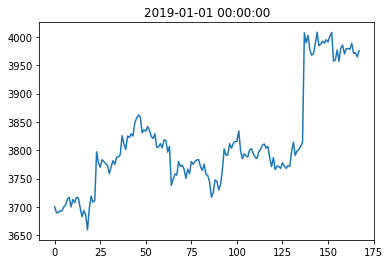

In [62]:
# visualize example 
random_date = datetimes_dt[start_idx] 

similar_dates = ranked_index[random_date] 

plt.plot(date_chart_dict[random_date]) 
plt.title(random_date)
print()

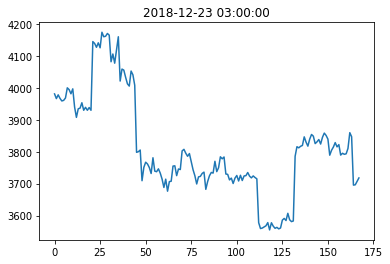

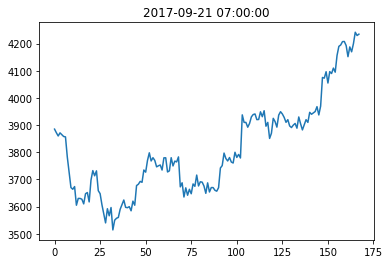

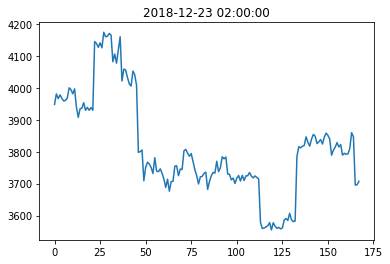

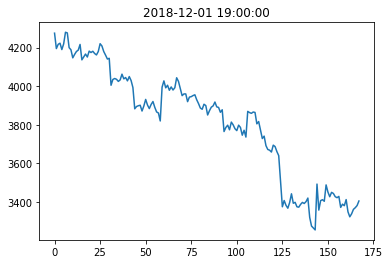

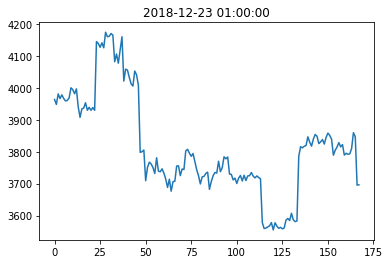

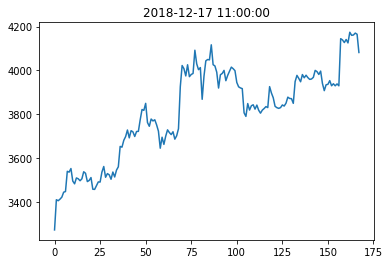

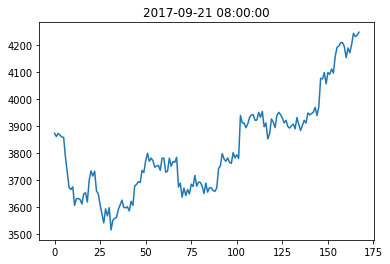

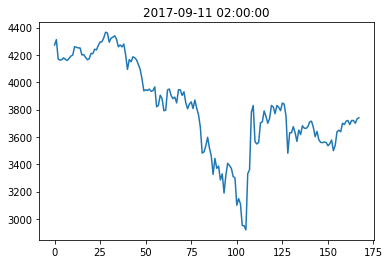

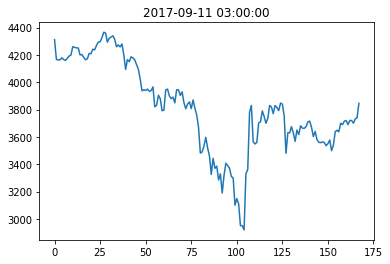

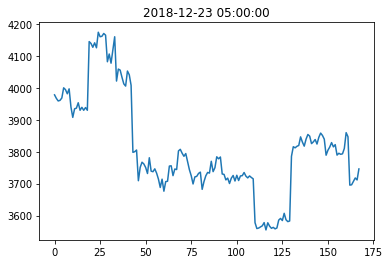

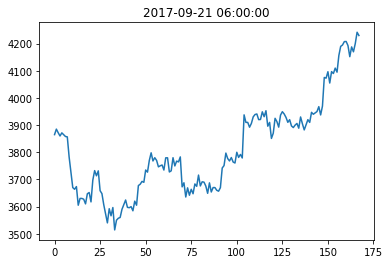

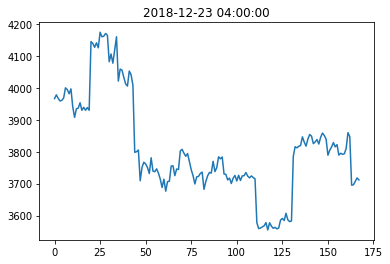

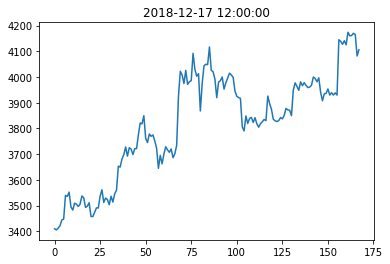

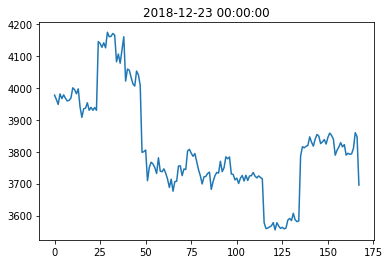

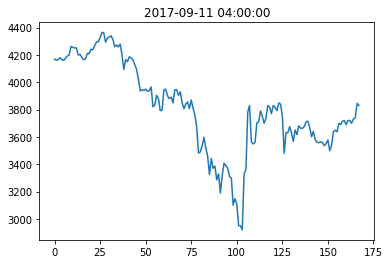

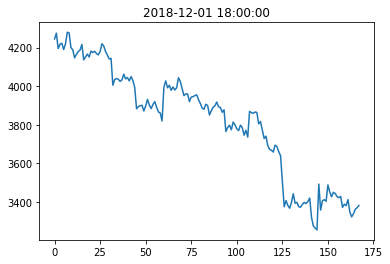

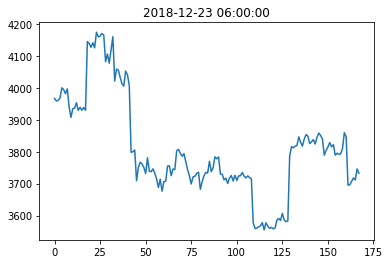

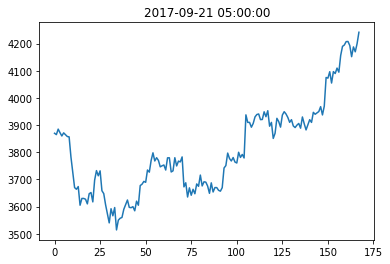

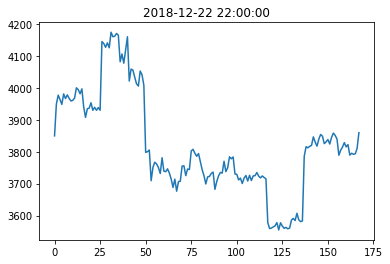

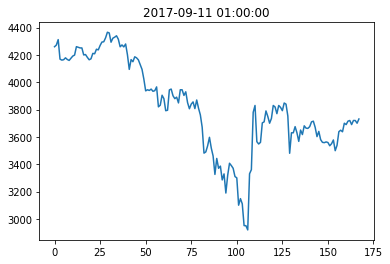

In [63]:
for i in range(len(similar_dates)): 
    plt.figure() 
    plt.title(similar_dates[i])
    plt.plot(date_chart_dict[similar_dates[i]]) 
    plt.show() 

# Example 2

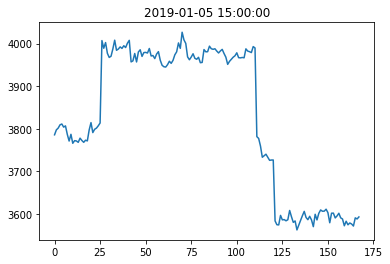

In [67]:
# visualize example 
random_date = datetimes_dt[start_idx+111] 

similar_dates = ranked_index[random_date] 

plt.plot(date_chart_dict[random_date]) 
plt.title(random_date)
print()

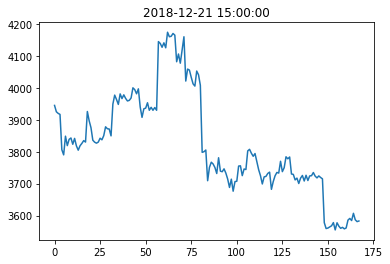

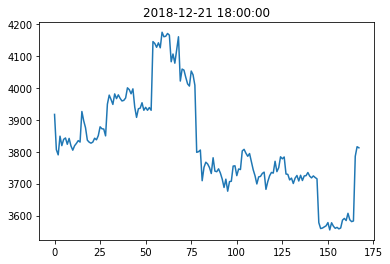

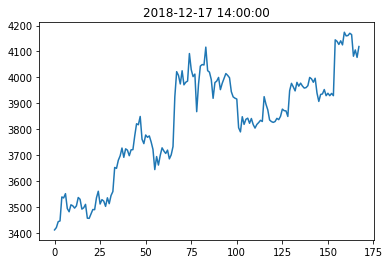

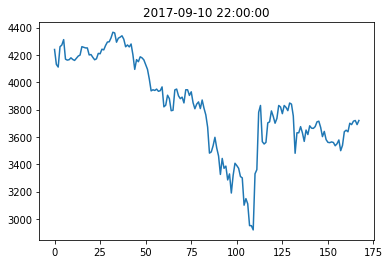

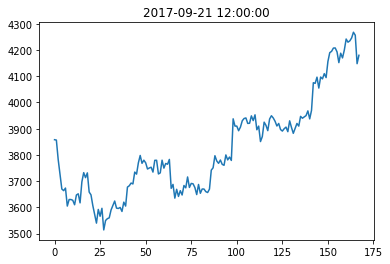

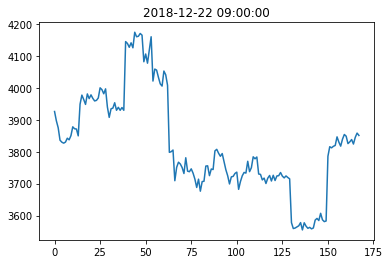

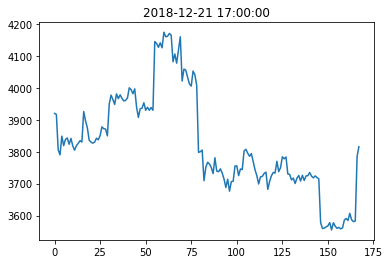

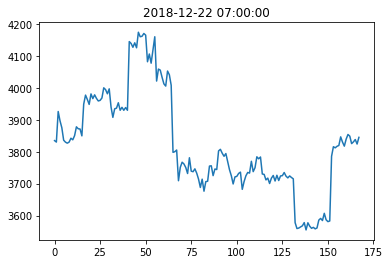

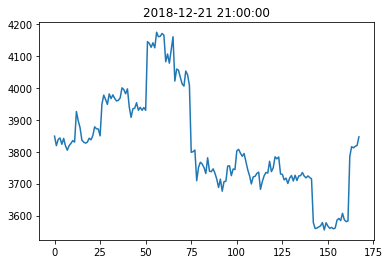

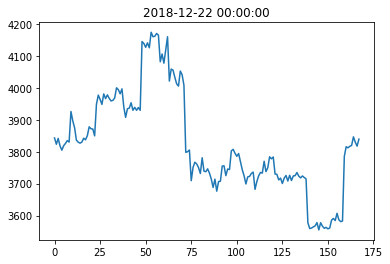

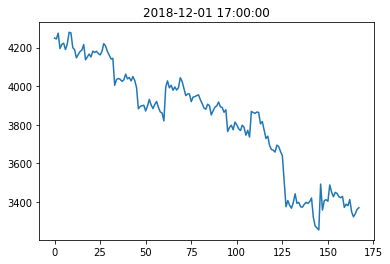

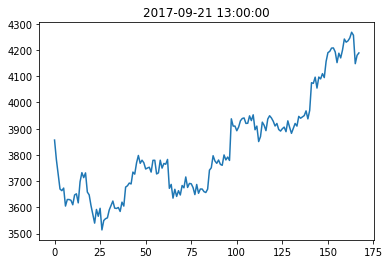

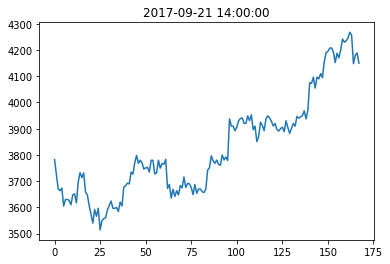

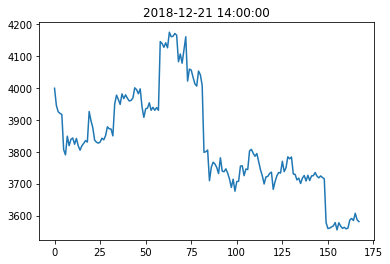

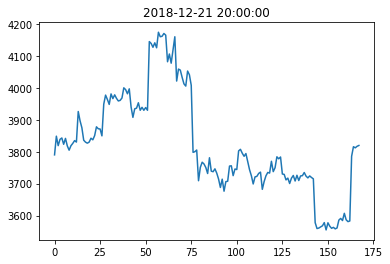

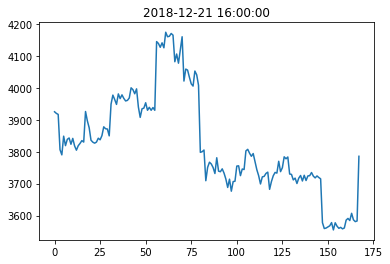

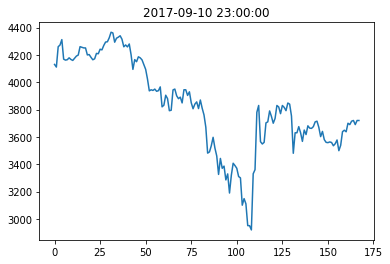

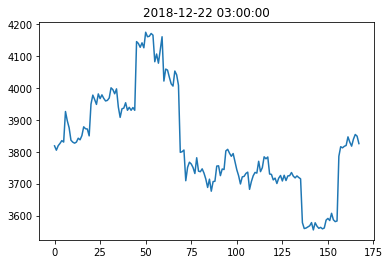

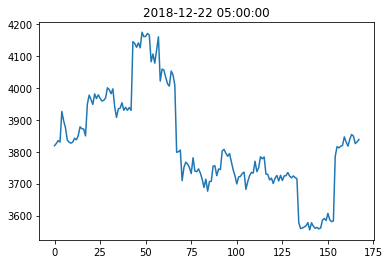

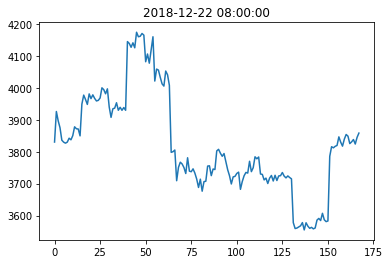

In [68]:
for i in range(len(similar_dates)): 
    plt.figure() 
    plt.title(similar_dates[i])
    plt.plot(date_chart_dict[similar_dates[i]]) 
    plt.show() 

# Example 3 

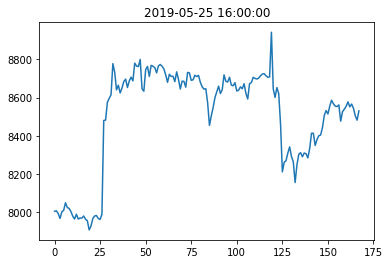

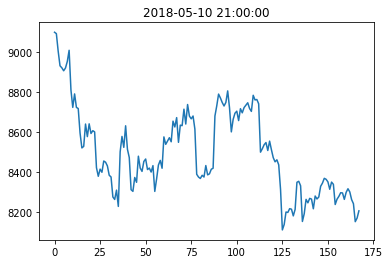

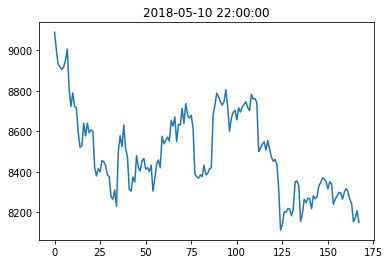

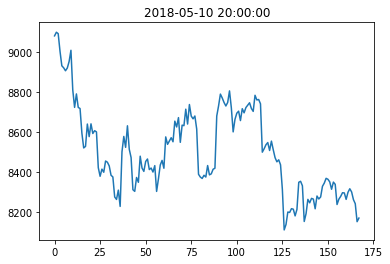

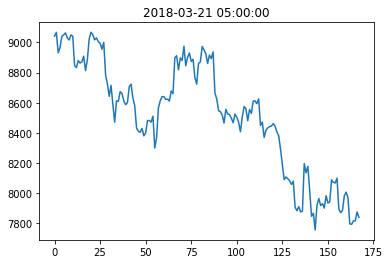

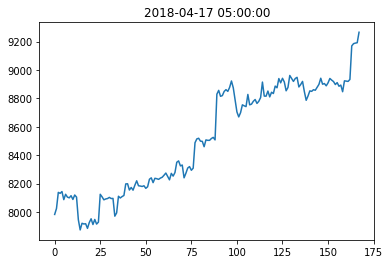

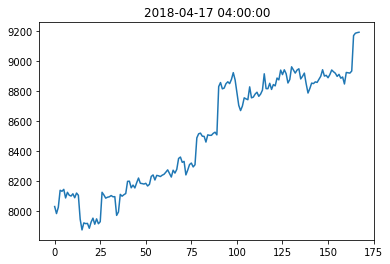

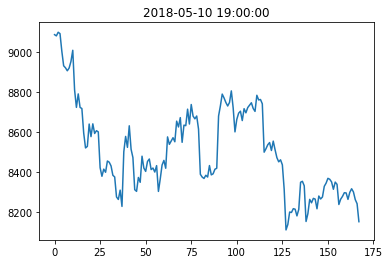

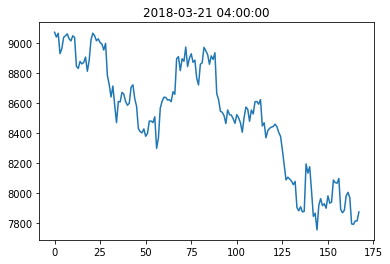

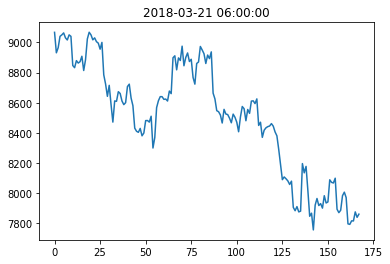

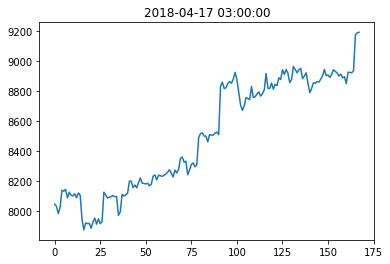

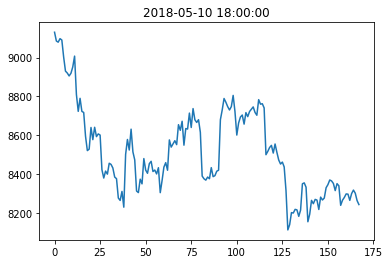

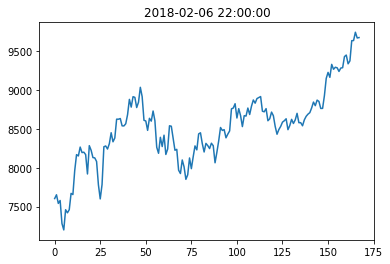

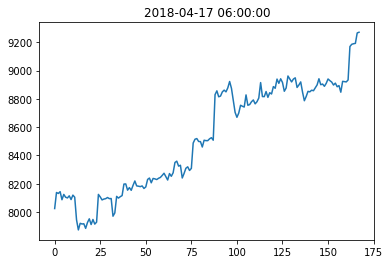

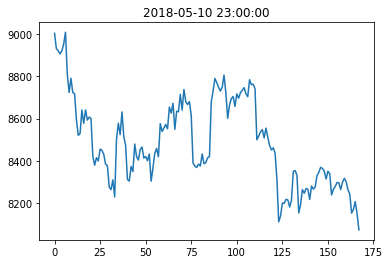

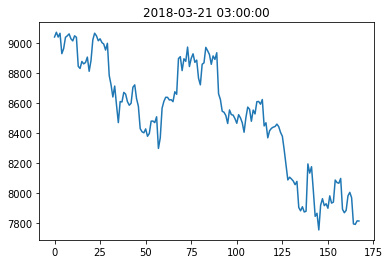

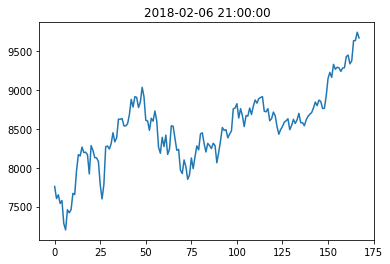

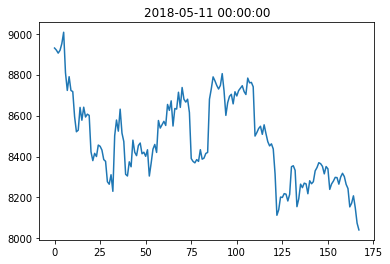

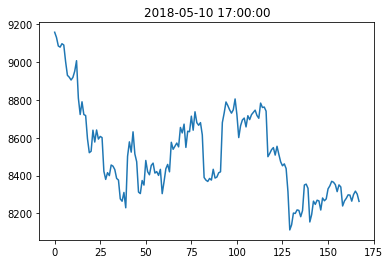

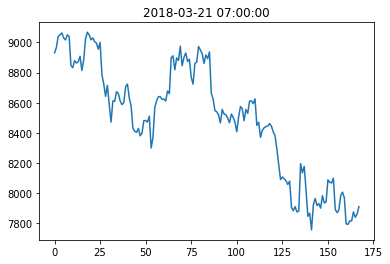

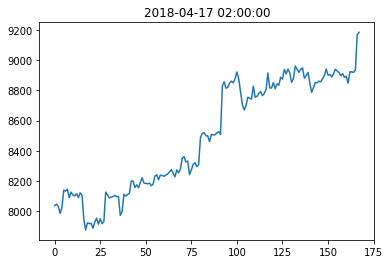

In [65]:
# visualize example 
random_date = datetimes_dt[start_idx+3456] 

similar_dates = ranked_index[random_date] 

plt.plot(date_chart_dict[random_date]) 
plt.title(random_date)
print()

for i in range(len(similar_dates)): 
    plt.figure() 
    plt.title(similar_dates[i])
    plt.plot(date_chart_dict[similar_dates[i]]) 
    plt.show() 